In [1]:
from subprocess import check_output as run_program, CalledProcessError, TimeoutExpired
import re
import random

GENERATED_PAT = re.compile('% Final active clauses: ([0-9]+)')
BLOCK = 10
LENGTH = 100
MIN = -5
MAX = 5
STEP = 0.5
DENOMINATOR = 1024

def vampire(problem, awrs):
    with open('/tmp/aw', 'w') as aw_f:
        for awr in awrs:
            for _ in range(BLOCK):
                aw_f.write(awr)

    try:
        output = run_program([
            'vampire-aw',
            '-t', '1',
            #'--avatar', 'off',
            '--saturation_algorithm', 'discount',
            '--statistics', 'full',
            '--proof', 'off',
            problem
        ], env={'VAMPIRE_AW_STREAM': '/tmp/aw'}, timeout=1).decode('ascii')
        found = GENERATED_PAT.search(output, re.MULTILINE)
        if found is None:
            return float('nan')

        return int(found.group(1))
    except CalledProcessError:
        return float('nan')
    except TimeoutExpired:
        return float('nan')
            
def log_to_awr(x):
    linear = 2.0 ** x
    age = int(DENOMINATOR * linear)
    weight = DENOMINATOR
    return f"{age} {weight}\n"

def random_awrs():
    start = random.uniform(MIN, MAX)
    logarithmic = [start]
    current = start
    for _ in range(LENGTH - 1):
        step = random.uniform(-STEP, STEP)
        current = min(max(current + step, MIN), MAX)
        logarithmic.append(current)
        
    return logarithmic

def random_vampire(problem):
    logarithmic = random_awrs()
    return (logarithmic, vampire(problem, [log_to_awr(x) for x in logarithmic]))

In [2]:
import csv
from tqdm import trange

PROBLEM = 'Problems/PRO/PRO017+2.p'

with open('./random.csv', 'w') as f:
    writer = csv.writer(f)
    for _ in trange(10000):
        logarithmic, active = random_vampire(PROBLEM)
        row = [active] + logarithmic
        writer.writerow(row)

100%|██████████| 10000/10000 [1:01:17<00:00,  2.72it/s]


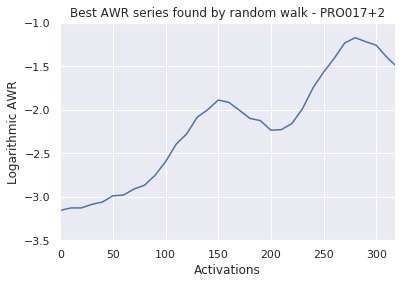

In [2]:
# %matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set()

STEPS = 318
LOGARITHMIC = [-3.1562166375503353,-3.0997426768755876,-3.126247666927843,-2.9642129598426,-2.952236423149577,-2.6307282474257296,-2.9304542056219613,-2.667246809101762,-2.79774521865869,-2.323663520878323,-1.8666700808160097,-1.5485222887229972,-1.8004293310522481,-1.5849770938109238,-2.067127900025346,-2.0202400633314945,-2.5067375346929555,-2.498575469350079,-2.2088567721934083,-1.9785521362180722,-2.363950181397562,-2.014472012334188,-1.5272603918568617,-1.3178340974476896,-0.8233741858660074,-0.9430756631846956,-0.8837567121894078,-1.1186127399513914,-1.5791705957850959,-1.8467777801076426,-1.6036787633051635,-1.7780674284403961,-1.7529763680671606,-1.8588926085707378,-1.9457405398568954,-2.4280121746037158,-2.6921713442093527,-2.7112500310276926,-2.8544864376595602,-3.1337511590729124,-3.4355001881381844,-3.2550002652510694,-2.930018650162049,-2.75529856032425,-3.1466815673113104,-2.7060272797874445,-2.2101860539371083,-2.539464890061333,-2.59467169958445,-2.5772405978143147,-2.4664850857932907,-2.2423892705552433,-1.7543430338086896,-1.2556401480815773,-1.3508560990822303,-1.0073977968020211,-0.6893408635179451,-0.9234759421784782,-0.7187367532124344,-0.45567413277477087,-0.013610797435075095,-0.31376028292782576,-0.7136574588071659,-0.61277018899547,-0.4756641753800326,-0.49045880769783157,-0.015827867010372643,0.4763143582006456,0.9397463345330147,0.6293968064835291,0.46897381779183733,0.39018801226929267,0.564631380953593,0.448628017135388,-0.03911776318739302,-0.3246334315072378,-0.6795554271916503,-0.540314623300576,-0.30945522248417334,-0.2767128075621277,-0.6158361479691357,-0.2628395561886985,0.19251411109764993,0.6182622426764254,0.5055086213353448,0.16888252063847375,0.4615773890891316,0.9271286077160902,0.9938445128887726,0.8682198934752786,0.7953325899889364,1.1171608710672052,1.012865402892489,0.8101353072255733,0.6479996107624136,0.4551826309542315,0.29040265582356983,0.6709363181028746,1.0344313188794914,0.6468350804055263]

data = pd.DataFrame({})
data['Activations'] = np.arange(0, 1000, 10)
#data['Logarithmic AWR'] = LOGARITHMIC
data['Logarithmic AWR'] = pd.DataFrame(LOGARITHMIC).rolling(7, min_periods=1).mean()

plt.xlim((0, STEPS))
plt.ylim((-3.5, -1.0))
plt.title("Best AWR series found by random walk - PRO017+2")
sns.lineplot(data=data, x='Activations', y='Logarithmic AWR')
plt.savefig('random-walk.pdf', bbox_inches='tight')